# Preprocessing

Modifico tutte le CT, in modo che siano pronte per i modelli.

In [2]:
import os
os.chdir("D:\kits19")
cwd = os.getcwd()
print(cwd)

D:\kits19


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import skimage.transform
from scipy.ndimage import zoom
from skimage import exposure
import cv2
from tqdm import tqdm
from PIL import Image

# Set numpy to print only 2 decimal digits for neatness
np.set_printoptions(precision=2, suppress=True)

In [4]:
data_path = "data/case_"
imaging_fname = "/imaging.nii.gz"
segmentation_fname = "/segmentation.nii.gz"

class Patient:
  def __init__(self, number):
      self.number = number
      
      self.imaging_path = self.get_im_data_path()
      self.imaging = nib.load(self.imaging_path)
      
      if number < 210: # segmentation file only exists for non-submission cases
        self.segmentation_path = self.get_seg_data_path()
        self.segmentation = nib.load(self.segmentation_path)

  def get_im_data_path(self):
      '''
      returns path to imaging file
      '''
      out = "00000"

      out = out[len(str(self.number)):]
      out += str(self.number)
      return data_path + out + imaging_fname
  
  def get_seg_data_path(self):
      '''
      returns path to segmentation file
      '''
      out = "00000"

      out = out[len(str(self.number)):]
      out += str(self.number)
      return data_path + out + segmentation_fname

  def rr(self, target_file, target_resolution=[1,1,1], target_shape=[192,192,192]):
    '''
    Target file can be either self.imaging or self.segmentation
    Function that returns reshaped and resized target block
    ''' 
    target_fig = target_file.get_fdata()

    # x,y,z
    vox_dim = (target_file.header['pixdim'][2], target_file.header['pixdim'][3], target_file.header['pixdim'][1])

    scale_vector = (vox_dim[0]/target_resolution[0],
                    vox_dim[1]/target_resolution[1],
                    vox_dim[2]/target_resolution[2])

    

    iso_target_fig = skimage.transform.rescale(target_fig, scale_vector, order=3, preserve_range=True,  mode='constant')
    
    # print(iso_target_fig.dtype) # float64
    
    factors = ( target_shape[0]/iso_target_fig.shape[0],
                target_shape[1]/iso_target_fig.shape[1],
                target_shape[2]/iso_target_fig.shape[2],)

    rr_target_cube = zoom(iso_target_fig, factors, order=3, mode='nearest')

    # print(rr_target_cube.dtype) # float64

    # rr = rescaled and reshaped
    # rr_target = nib.Nifti1Image(rr_target_fig, target_file.affine)

    # # setto le dimensioni manualmente, sono abbastanza sicuro che il rescaling sia avvenuto correttamente

    # for i in range(3):
    #   rr_target.header['pixdim'][i+1] = target_resolution[i]

    # for i in range(3):
    #   rr_target.affine[i][2-i] = -target_resolution[i]

    return rr_target_cube

  def process_imaging(self, target_resolution=[1,1,1], target_shape=[192,256,256]):
    '''
    function that returns reshaped, resized, normalized imaging block
    '''

    rr_imaging = self.rr(self.imaging, target_resolution, target_shape)
    output = cv2.normalize(rr_imaging, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_8UC1)
    return output

  def process_segmentation(self, target_resolution=[1,1,1], target_shape=[192,256,256]):
    '''
    function that returns reshaped, resized segmentation block
    '''

    output = self.rr(self.segmentation, target_resolution, target_shape)

    # might break things (it does, kinda)
    #output = cv2.normalize(rr_segmentation, None, alpha = 0, beta = 3, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_8UC1)
    
    output = np.rint(output)
    output = output.astype('uint8')

    return output

In [4]:
def imshow_from_list(imgs_and_segs):
  '''
  helper function that given a list of tuples returns img and seg figs next to each other
  '''
  n = len(imgs_and_segs)
  fig = plt.figure(figsize=(16, n*8))
  for i in range(0,2*n,2):
    a = fig.add_subplot(n,2,i+1)
    imgplot = plt.imshow(imgs_and_segs[i//2][0], cmap='gray')
    plt.title("Height: {}".format(i))
    a = fig.add_subplot(n,2,i+2)
    imgplot = plt.imshow(imgs_and_segs[i//2][1])
    
  plt.show()

In [3]:
def get_number(n):
  '''
  returns num padded with zeros
  '''
  out = "00000"

  out = out[len(str(n)):]
  out += str(n)
  return out

---

Iterate over all the cases, get images, kidney and tumor masks

In [34]:
# get train/test data

clahe_img = cv2.createCLAHE (clipLimit = 2.0, tileGridSize = (8, 8))

for i in tqdm(range(1,168)): # 168:210 = 80:100
  fig_path = '//processed_data//sub_images'
  kidney_path = '//processed_data//test_kidney_labels'
  tumor_path = '//processed_data//test_tumor_labels'
  combined_mask_path = 'D:\\kits19\\processed_data\\combined_labels'

  pat = Patient(i)
  #img_cube = pat.process_imaging(target_shape=[192, 256, 256])
  seg_cube = pat.process_segmentation(target_shape=[192, 256, 256])

  for j in range(191):
    # name_im = fig_path + '/case_' + get_number(i) + '_im_' + get_number(j) + '.png'
    # name_seg = kidney_path + '/case_' + get_number(i) + '_seg_' + get_number(j) + '.png'
    # name_tum = tumor_path + '/case_' + get_number(i) + '_tum_' + get_number(j) + '.png'

    name_combined = combined_mask_path + '/case_' + get_number(i) + '_comb_' + get_number(j) + '.png'
    
    #apply clahe on imaging for better results
    # img_slice = Image.fromarray(clahe_img.apply(img_cube[j,:,:]))
    # img_slice.save(name_im)
    
    # # create kidney mask
    # seg_cube_at_j = seg_cube[j,:,:]
    # seg_cube_at_j[seg_cube_at_j>1] = 1
    # seg_cube_at_j = seg_cube_at_j*255
    # seg_pic = Image.fromarray(seg_cube_at_j)
    # seg_pic.save(name_seg)

    # create tumor mask
    # tum_cube_at_j = seg_cube[j,:,:]
    # tum_cube_at_j[tum_cube_at_j==1] = 0 # set kidney values to 0
    # tum_cube_at_j[tum_cube_at_j==2] = 1 # set tumor values to 1
    # tum_cube_at_j = tum_cube_at_j*255
    # tum_pic = Image.fromarray(tum_cube_at_j)
    # tum_pic.save(name_tum)

    # create combined mask (tumor and kidney)
    # this time image will have low contrast, (np.unique(comb_pic) >> [0,1,2]) so that mask is already encoded
    comb_slice_at_j = seg_cube[j,:,:]
    comb_pic = Image.fromarray(comb_slice_at_j)
    comb_pic.save(name_combined)




100%|██████████| 167/167 [2:12:13<00:00, 47.51s/it]  


In [ ]:
# verify results
pat = Patient(1)
seg_cube = pat.process_segmentation(target_shape=[192, 256, 256])

[0 1 2]


'D:\\kits19'

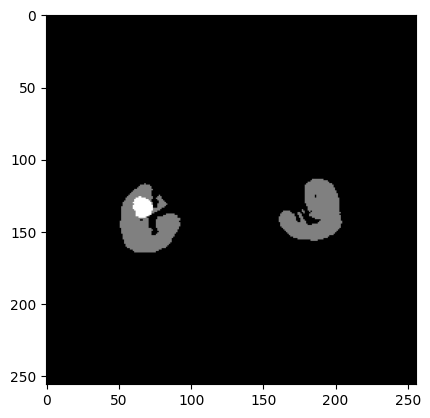

In [30]:
comb_slice_at_j = seg_cube[84,:,:]

print(np.unique(comb_slice_at_j))

plt.imshow(comb_slice_at_j, cmap='gray')

comb_pic = Image.fromarray(comb_slice_at_j*127)
comb_pic.save('TEST3.png')
os.getcwd()